In [1]:
import pickle
import numpy as np
import matplotlib.pylab as plt
import os
from scipy import interpolate
import torch

from model import CNN_Model, LSTM_Model_RUL, CNN_Model_RUL, Net, Net_new, Autoencoder, LSTM_Model
from util_FPC import EarlyStopping, get_fpc,plot_RUL, get_data, get_change_indices
from train_model import train_model,perform_n_folds
from import_file import *
from dataloader import get_RUL_dataloader
from torch.utils.data import Dataset, DataLoader
from dataloader import battery_dataloader

In [2]:
# def interp(v, q, num):
#     f = interpolate.interp1d(v,q,kind='linear')
#     v_new = np.linspace(v[0],v[-1],num)
#     q_new = f(v_new)
#     vq_new = np.concatenate((v_new.reshape(-1,1),q_new.reshape(-1,1)),axis=1)
#     return q_new

# n_cyc = 100
# in_stride = 10


# v_low = 3.36
# v_upp = 3.60
# q_low = 610
# q_upp = 1190
# rul_factor = 3000
# cap_factor = 1190
# fea_num =   1

# data_features = []
# for name in os.listdir("./Datasets/our_data")[0:]:
#     name = name[0:-4]
#     bat1 = pickle.load(open(r'./Datasets/our_data/'+name+'.pkl', 'rb'))
#     # list(bat1['1-2']['data'].keys())[9:]
#     A_rul = bat1[name]['rul']
#     A_dq = bat1[name]['dq']
#     A_df = bat1[name]['data']
#     all_idx = list(A_dq.keys())[9:]
#     all_fea, rul_lbl, cap_lbl = [], [], []
#     for cyc in all_idx:
#         tmp = A_df[cyc]
#         tmp = tmp.loc[tmp['Status'].apply(lambda x: not 'discharge' in x)]
        
#         left = (tmp['Current (mA)']<5000).argmax() + 1
#         right = (tmp['Current (mA)']<1090).argmax() - 2

#         tmp = tmp.iloc[left:right]

#         tmp_v = tmp['Voltage (V)'].values
#         tmp_q = tmp['Capacity (mAh)'].values
#         tmp_t = tmp['Time (s)'].values
#         v_fea = interp(tmp_t, tmp_v, fea_num)
#         q_fea = interp(tmp_t, tmp_q, fea_num)

#         tmp_fea = np.hstack((v_fea.reshape(-1,1), q_fea.reshape(-1,1)))
        
#         all_fea.append(np.expand_dims(tmp_fea,axis=0))
#         rul_lbl.append(A_rul[cyc])
        
#         cap_lbl.append(A_dq[cyc])
            
        
        
#     all_fea = np.vstack(all_fea)
#     rul_lbl = np.array(rul_lbl)
#     cap_lbl = np.array(cap_lbl)/cap_factor
    
#     all_fea_c = all_fea.copy()
#     all_fea_c[:,:,0] = (all_fea_c[:,:,0]-v_low)/(v_upp-v_low)
#     all_fea_c[:,:,1] = (all_fea_c[:,:,1]-q_low)/(q_upp-q_low)
#     dif_fea = all_fea_c - all_fea_c[0:1,:,:]
#     all_fea = np.concatenate((all_fea,dif_fea),axis=2)
    

#     data_features.append((all_fea,cap_lbl))
#     # all_fea = np.lib.stride_tricks.sliding_window_view(all_fea,(n_cyc,fea_num,4))
#     # cap_lbl = np.lib.stride_tricks.sliding_window_view(cap_lbl,(n_cyc,))
#     # all_fea = all_fea.squeeze(axis=(1,2,))
#     # rul_lbl = rul_lbl[n_cyc-1:]
#     # all_fea = all_fea[:,(in_stride - 1)::in_stride,:,:]
#     # cap_lbl = cap_lbl[:,(in_stride - 1)::in_stride,]
    
#     # all_fea_new = np.zeros(all_fea.shape)
#     # all_fea_new[:,:,:,0] = (all_fea[:,:,:,0]-v_low)/(v_upp-v_low)
#     # all_fea_new[:,:,:,1] = (all_fea[:,:,:,1]-q_low)/(q_upp-q_low)
#     # all_fea_new[:,:,:,2] = all_fea[:,:,:,2]
#     # all_fea_new[:,:,:,3] = all_fea[:,:,:,3]
#     # print(f'{name} length is {all_fea_new.shape[0]}', 
#     #       'v_max:', '%.4f'%all_fea_new[:,:,:,0].max(),
#     #       'q_max:', '%.4f'%all_fea_new[:,:,:,1].max(),
#     #       'dv_max:', '%.4f'%all_fea_new[:,:,:,2].max(), 
#     #       'dq_max:', '%.4f'%all_fea_new[:,:,:,3].max())
#     # rul_lbl = rul_lbl / rul_factor
#     # cap_lbl = cap_lbl / cap_factor
#     # plt.ylim([0.85, 1.25])
#     plt.plot(cap_lbl)
#     plt.xlabel("Cycles")
#     plt.ylabel("Discharge capacity (Ah)")

# np.save(f"Datasets/snl_data_{fea_num}.npy", np.array(data_features), allow_pickle=True)

In [3]:
fea_num =1
discharge_capacities_SNL = np.load(f"./Datasets/snl_data_{fea_num}.npy",allow_pickle=True)

name_start_train = 0
name_start_test = 70

d = []
for battery_temp in discharge_capacities_SNL:
    a = np.squeeze(battery_temp[0], axis = 1)     # Voltage/Current Features
    b = np.expand_dims(battery_temp[1], axis =1)  # Discharge Capccity
    c = np.concatenate((b,a), axis =1).T
    d.append(c)

discharge_capacities_SNL = d

In [4]:
len(discharge_capacities_SNL)

77

In [5]:


    


# def get_change_indices(model,discharge_capacities,channels,get_saved_indices, version):

#     changes_train = []
#     changes_test = []
#     epochs = 50
#     # os.mkdir("/kaggle/working/change_indices")

#     ch = ''.join(map(str,channels))
#     if(not get_saved_indices):
            
#         for channels in [channels]: 
#             print("Channels used : ", channels)
#             percentage  = 0.10  # 5 percent data
#             window_size = 50    # window size
#             stride = 1          # stride
            
#             train_data,FPC_data,FPC_data_dict = get_data_SNL(discharge_capacities[0:70],percentage,window_size,stride,channels,type = "train")
#             test_data,test_data_dict  = get_data_SNL(discharge_capacities[70:],None,window_size,stride,channels,type= "test")
            
#             obj_train  = battery_dataloader(train_data)
#             obj_FPC  = battery_dataloader(FPC_data)
#             obj_test  = battery_dataloader(test_data)

#             train_dataloader = DataLoader(obj_train, batch_size=8,shuffle=True)
#             FPC_dataloader   = DataLoader(obj_FPC,batch_size=1,shuffle=False)
#             test_dataloader = DataLoader(obj_test, batch_size=1,shuffle=False)

#             print("Shape of a batch    :",next(iter(train_dataloader))[0].shape)
    

#             batteries_train =[i for i in range (70)]
#             batteries_test= [70+i for i in range(0,7)]

           
#             change_percentage_train, change_indices_train =  get_fpc(model,batteries_train,discharge_capacities,FPC_data_dict,False, False,True,"")
#             change_percentage_test, change_indices_test =  get_fpc(model,batteries_test,discharge_capacities,test_data_dict,False, False,False,"")

            

#             changes_train.append(np.mean(change_percentage_train))
#             changes_test.append(np.mean(change_percentage_test))

#             print("Mean FPC for Training is {}and Test is {} :".format(np.mean(changes_train), np.mean(changes_test)))
            
            
#             if(os.path.exists("./change_indices") == False):
#                 os.mkdir("./change_indices")

#             np.save(f"./change_indices/change_indices_SNL_train_{ch}_version{version}.npy",change_indices_train, allow_pickle=True)
#             np.save(f"./change_indices/change_indices_SNL_test_{ch}_version{version}.npy",change_indices_test, allow_pickle=True)

#             np.save(f"./change_indices/change_percentage_SNL_train_{ch}_version{version}.npy",change_percentage_train, allow_pickle=True)
#             np.save(f"./change_indices/change_percentage_SNL_test_{ch}_version{version}.npy",change_percentage_test, allow_pickle=True)

#     else:
#         print("Loading Old Indices")
#         change_indices_train = np.load(f"./change_indices/change_indices_SNL_train_{ch}_version{version}.npy" , allow_pickle=True)
#         change_indices_test = np.load(f"./change_indices/change_indices_SNL_test_{ch}_version{version}.npy",allow_pickle=True)
        
#         change_percentage_train = np.load(f"./change_indices/change_percentage_SNL_train_{ch}_version{version}.npy",allow_pickle=True)
#         change_percentage_test = np.load(f"./change_indices/change_percentage_SNL_test_{ch}_version{version}.npy",allow_pickle=True)

#         print("Mean FPC for Training is {}and Test is {}".format(np.mean(change_percentage_train), np.mean(change_percentage_test)))

#     return change_indices_train, change_indices_test, change_percentage_train, change_percentage_test


    

In [6]:
percentage  = 0.10  # 10 percent data
window_size = 50    # window size
stride = 1          # stride
channels  =[0] # channels


train_data_SNL, FPC_data_SNL, FPC_data_dict_SNL= get_data(discharge_capacities_SNL[0:70], 
                                                              percentage, window_size , stride, channels, "train" , name_start = name_start_train)
test_data_SNL,test_data_dict_SNL  = get_data(discharge_capacities_SNL[70:],None,window_size,stride,channels,type= "test",name_start = name_start_test)


In [7]:
obj_train_SNL  = battery_dataloader(train_data_SNL)
obj_FPC_SNL  = battery_dataloader(FPC_data_SNL)
obj_test_SNL  = battery_dataloader(test_data_SNL)

train_dataloader_SNL = DataLoader(obj_train_SNL, batch_size=8,shuffle=True)
FPC_dataloader_SNL   = DataLoader(obj_FPC_SNL,batch_size=1,shuffle=False)
test_dataloader_SNL = DataLoader(obj_test_SNL, batch_size=1,shuffle=False)


In [8]:
print("Shape of a batch    :",next(iter(train_dataloader_SNL))[0].shape)

Shape of a batch    : torch.Size([8, 1, 50])


In [9]:
device = "cpu"
epochs = 2
learning_rate = 0.001

pretrained = True
load_pretrained = False
version = 1

ch = ''.join(map(str,channels))

# model = CNN_Model(window_size,len(channels))
model = LSTM_Model(window_size,len(channels))

model_dir = "./Weights/FPC/"
model_path = f'{model_dir}/model_SNL_f{ch}_f{window_size}_f{model.name}_f{version}.pth'

if(load_pretrained):
    model.load_state_dict(torch.load(model_path, map_location=device ))

model.to(device)


optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas= (0.9, 0.99))
criterion = nn.BCELoss()

early_stopping = EarlyStopping(patience=20)


if(pretrained):
    
    model.load_state_dict(torch.load(model_path, map_location=device ))
    model.to(device)
else:
    model = train_model(model, optimizer, criterion, early_stopping,train_dataloader_SNL,epochs,learning_rate,load_pretrained,model_path,version)

version = 2
# Get Change Indices


In [10]:
# for data in train_dataloader_SNL:
#     print(data)
#     exit()

<Figure size 432x288 with 0 Axes>

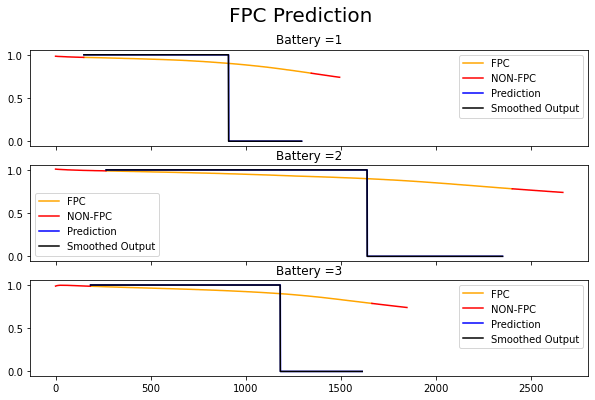

In [11]:
batteries = [i for i in range(0,3)]
_,_ = get_fpc(model,batteries,discharge_capacities_SNL,FPC_data_dict_SNL,True, True,True,"Outputs/FPC_Training_SNL")

In [12]:
change_indices_train,change_indices_test, _, _ = get_change_indices(model,discharge_capacities_SNL,
                                                                    channels,get_saved_indices = True, version = 1, name_start_train=name_start_train, name_start_test= name_start_test, dataset = "SNL")
change_indices_all = np.concatenate((change_indices_train,change_indices_test))

Loading Old Indices
Mean FPC for Training is 92.48268069792432and Test is 89.00224581834956


In [16]:
channels_RUL = [0]
window_size_RUL = 50
stride_RUL =1
c_RUL = ''.join(map(str,channels_RUL))

n_folds = 5
scenario = 1
# learning_rate = 0.01
learning_rate = 0.0001
epochs = 10

parameters = {
    "window_size" : window_size,
    "stride": stride,
    "channels": channels_RUL,
    "epochs": epochs,
    "learning_rate": learning_rate
}



model_RUL = LSTM_Model_RUL(window_size,len(channels))  # LSTM Model
# model_RUL = Net(len(channels))    # Transformer Model
#model_RUL = CNN_Model_RUL(window_size,channels)    # CNN Model

optimizer = torch.optim.Adam(model_RUL.parameters(), lr = learning_rate, betas= (0.9, 0.99))
# criterion = nn.L1Loss()
criterion = nn.MSELoss()
early_stopping = EarlyStopping(patience=50)

version = 1
pretrained_RUL_scenario1 = False
load_pretrained_scenario1  = False

model_dir_scenario1 = "./Weights/Scenario1/"
model_path_scenario1 = f'{model_dir_scenario1}/model_SNL_f{model_RUL.name}_f{c_RUL}_f{window_size_RUL}_f{version}.pth'

if(pretrained_RUL_scenario1):
    print("Loading a Pre-trained Model")
    model_RUL.load_state_dict(torch.load(model_path_scenario1,map_location= device))
    test_batteries = np.load("./Test_data/test_batteries_SNL.npy",allow_pickle=True)
    train_batteries = np.load("./Test_data/train_batteries_SNL.npy",allow_pickle=True)
    
    
else:
    if(load_pretrained_scenario1):
        print("Training further on already trained model")
        model_RUL.load_state_dict(torch.load(model_path_scenario1,map_location= device))
        model_RUL, test_dataloader_RUL, test_batteries = perform_n_folds(model_RUL,n_folds,discharge_capacities_SNL,change_indices_all,criterion, optimizer, early_stopping,
                    pretrained_RUL_scenario1, model_path_scenario1,scenario,parameters, version)
    else:
        print("Training a new Model")
        model_RUL, test_dataloader_RUL, test_batteries, train_batteries = perform_n_folds(model_RUL,n_folds,discharge_capacities_SNL,change_indices_all,criterion, optimizer, early_stopping,
                    pretrained_RUL_scenario1, model_path_scenario1,scenario,parameters, version)
        np.save(f"./Test_data/test_batteries_SNL.npy", test_batteries, allow_pickle=True)
        np.save(f"./Test_data/train_batteries_SNL.npy", train_batteries, allow_pickle=True)


Training a new Model
*********************  Fold = 0  ********************* 


Epoch = 0, Loss = 0.15851380884447658 
Epoch = 1, Loss = 0.06977655967674777 
Epoch = 2, Loss = 0.05423339043629079 
Epoch = 3, Loss = 0.009942483828041422 
Epoch = 4, Loss = 0.0008597094568230365 
Epoch = 5, Loss = 0.0007947505234596354 
Epoch = 6, Loss = 0.0007791870191625456 
Epoch = 7, Loss = 0.0007626463857778709 
Epoch = 8, Loss = 0.000748461145452335 
Epoch = 9, Loss = 0.0007240264979229987 

 Average Time per Epoch : 6.193884921073914


Test loss = 0.00043582709388356364 


*********************  Fold = 1  ********************* 


Epoch = 0, Loss = 0.16081403884309334 
Epoch = 1, Loss = 0.07180547165792978 
Epoch = 2, Loss = 0.07150544475513342 
Epoch = 3, Loss = 0.0715083081641759 
EarlyStopping counter: 1 out of 50
Epoch = 4, Loss = 0.07150893218915527 
EarlyStopping counter: 2 out of 50
Epoch = 5, Loss = 0.07151219783774748 
EarlyStopping counter: 3 out of 50
Epoch = 6, Loss = 0.07150845014840625 

In [17]:
# MSE= 0.002822460839524865, MAE =0.0460253544151783 , MAPE = 0.12208760529756546
# [4, 9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74]
# [0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 32, 33, 35, 36, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 50, 51, 52, 
    #53, 55, 56, 57, 58, 60, 61, 62, 63, 65, 66, 67, 68, 70, 71, 72, 73, 75, 76]

MSE= 0.0009311149478890002, MAE =0.024237921461462975 , MAPE = 0.0793507844209671


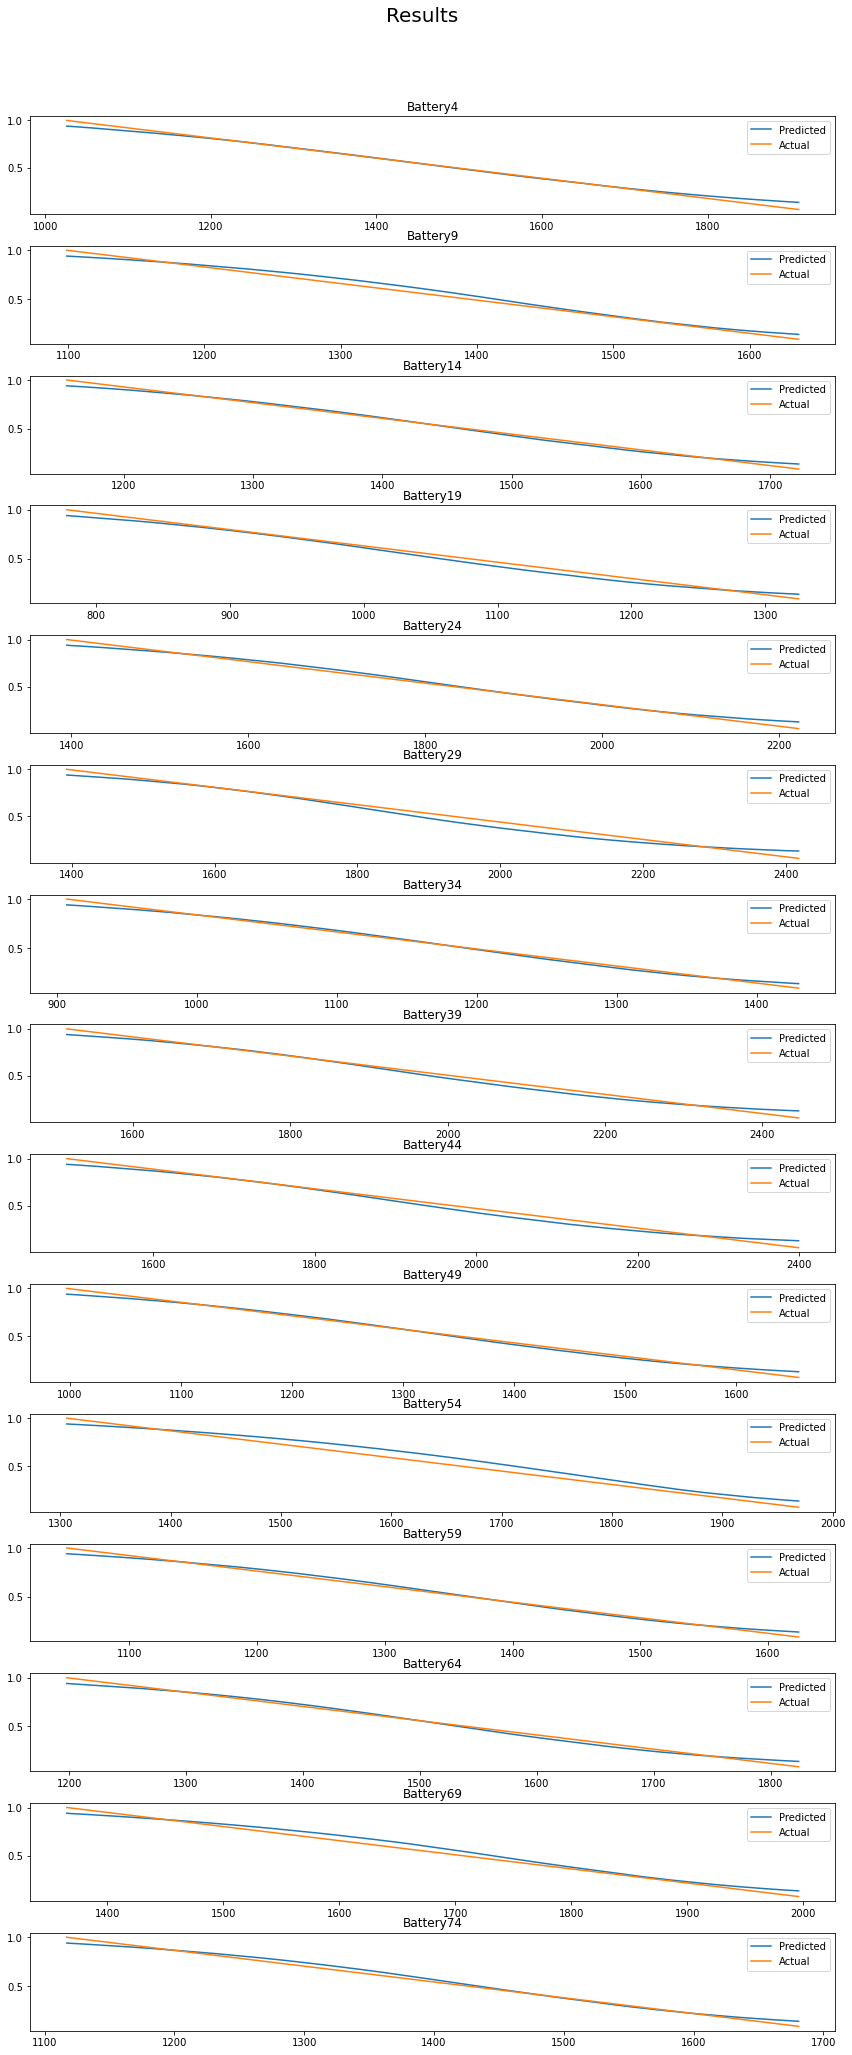

In [18]:
_, _, test_dataloader_RUL = get_RUL_dataloader(discharge_capacities_SNL, train_batteries, test_batteries, 
                                              change_indices_all, parameters["window_size"],
                                              parameters["stride"],parameters["channels"] ,scenario)

plot_RUL(model_RUL,discharge_capacities_SNL,test_batteries,test_dataloader_RUL,
         change_indices_all,"Outputs/scenario1_RUL_prediction_test_SNL")